In [1]:
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.signal import convolve2d
from scipy.optimize import minimize
from scipy.ndimage.filters import gaussian_filter

#%matplotlib qt
%matplotlib inline

# Calibration

In [33]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

Calibration images: 17
Calibration result: 1.0298149716172826


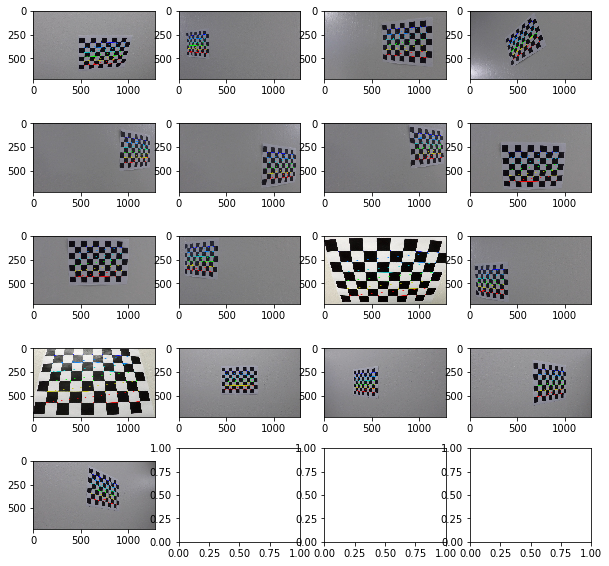

In [11]:
# Calibrate

DRAW = True
if DRAW: 
    fig, axes = plt.subplots(5, 4, figsize=(10, 10))
    axes = axes.flatten()
    iax = 0

objpoints = []
imgpoints = []

for fname in glob.glob('camera_cal/*.jpg'):
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_size = gray.shape[::-1]
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        if DRAW:
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            axes[iax].imshow(img)
            iax += 1
            
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print('Calibration images:', len(imgpoints))
print('Calibration result:', ret)

# pickle.dump((mtx, dist), open('camera_cal/mtx_dist.p', 'wb'))

In [43]:
# Test corrected and warped image

(mtx, dist) = pickle.load(open('camera_cal/mtx_dist.p', 'rb'))

img = mpimg.imread('camera_cal/calibration3.jpg')
#img = mpimg.imread('test_images/straight_lines1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

ret, corners = cv2.findChessboardCorners(cv2.cvtColor(dst, cv2.COLOR_RGB2GRAY), (9, 6), None)
if ret:
    M = cv2.getPerspectiveTransform(corners.reshape(-1,2)[(0,8,45,53),:], (objp[(0,8,45,53),:2] + 2)*100)
    warped = cv2.warpPerspective(dst, M, (1200,900), flags=cv2.INTER_LINEAR)

f, ax = plt.subplots(1,3 if ret else 2,figsize=(24,9))
f.tight_layout()
ax[0].imshow(img)
ax[1].imshow(dst)
if ret: ax[2].imshow(warped)
    
# mpimg.imsave('output_images/straight_lines1_undist.jpg', dst)

# Perspective transform

In [70]:
(D_mtx, D_dist) = pickle.load(open('camera_cal/mtx_dist.p', 'rb'))
lane_x1 = 640+(195-640)*0.75
lane_x2 = 640+(1116-640)*0.75
ym_per_pix = 35/720 # image height ~35m long
xm_per_pix = 3.7/(lane_x2-lane_x1) # lane width 3.7m

corners_from = np.array([[195, 720], [570, 466], [714, 466], [1116, 720]], dtype=np.float32)
corners_to = np.array([[lane_x1, 720], [lane_x1, 300], [lane_x2, 300], [lane_x2, 720]], dtype=np.float32)
M_perspective = cv2.getPerspectiveTransform(corners_from, corners_to)
M_perspective_inv = cv2.getPerspectiveTransform(corners_to, corners_from)

def undistort_transform(img):
    return cv2.undistort(img, D_mtx, D_dist, None, D_mtx)
    
def undistort_warp_transform(img):
    dst = cv2.undistort(img, D_mtx, D_dist, None, D_mtx)
    warped = cv2.warpPerspective(dst, M_perspective, (1280,720), flags=cv2.INTER_LINEAR)
    return warped

def unwarp_transform_p(p):
    p3 = np.ones(3)
    p3[:2] = p
    pi = M_perspective_inv.dot(p3)
    return pi[:2] / pi[2]

In [27]:
# Test

img = mpimg.imread('test_images/straight_lines2.jpg')
warped = undistort_warp_transform(img)

plt.figure()
plt.imshow(warped)
plt.plot([lane_x1,lane_x1],[0,720])
plt.plot([lane_x2,lane_x2],[0,720])

In [19]:
%matplotlib qt

# Color transform

In [3]:
def transform_threshold_binary(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

In [51]:
# Test

img = mpimg.imread('test_images/test5.jpg')

binary = transform_threshold_binary(img)
mpimg.imsave('output_images/test5_thresholded.jpg', binary, cmap='gray')

warped = undistort_warp_transform(binary)
mpimg.imsave('output_images/test5_thresholded_warped.jpg', warped, cmap='gray')

plt.imshow(warped, cmap='gray')

# Curvature

In [77]:
def curve_x(y, coef):
    y1 = np.max(y) - y
    return coef[0] + y1 * coef[1] + y1 * y1 * coef[2]

def fit_curve(warped, prev1=None, prev2=None):
    def cost_fn(coef):
        y = np.arange(conv.shape[0])
        x = np.round(curve_x(y, coef))
        mask = (x >= 0) & (x < conv.shape[1])
        return -np.sum(conv[y[mask], x.astype(np.int32)[mask]])
    
    def select_better_fit(results, bounds0):
        res = None
        for r in results:
            if r is not None and r.success and (res is None or r.fun < res.fun):
                if r.x[0] > bounds0[0] and r.x[0] < bounds0[1]:
                    res = r
        return res
    
    conv = gaussian_filter(warped*1.0, 20)
    
    res10 = minimize(cost_fn, np.array(prev1), method='nelder-mead') if prev1 is not None else None
    res11 = minimize(cost_fn, np.array([lane_x1-100., 0., 0.]), method='nelder-mead')
    res12 = minimize(cost_fn, np.array([lane_x1+100., 0., 0.]), method='nelder-mead')
    res1 = select_better_fit([res10, res11, res12], [100., 600.])
    
    res20 = minimize(cost_fn, np.array(prev2), method='nelder-mead') if prev2 is not None else None
    res21 = minimize(cost_fn, np.array([lane_x2-100., 0., 0.]), method='nelder-mead')
    res22 = minimize(cost_fn, np.array([lane_x2+100., 0., 0.]), method='nelder-mead')
    res2 = select_better_fit([res20, res21, res22], [750., 1280.])
    
    return (res1.x if res1 else None, res2.x if res2 else None)

def curve_geometry(coef1, coef2):
    def radius(coef):
        a = coef[2] * xm_per_pix / ym_per_pix ** 2
        b = coef[1] * xm_per_pix / ym_per_pix
        return (1 + b ** 2) ** (3/2) / 2 / abs(a)
    
    width = (coef2[0]-coef1[0]) * xm_per_pix
    offset = ((coef1[0]+coef2[0])/2 - 640) * xm_per_pix
    
    radius1 = radius(coef1)
    radius2 = radius(coef2)
    
    return (width, offset, (radius1+radius2)/2)

In [81]:
# Test

img = mpimg.imread('test_images/test6.jpg')

%time binary = transform_threshold_binary(img)
%time warped = undistort_warp_transform(binary)
mpimg.imsave('output_images/test6_thresholded_warped.jpg', warped, cmap='gray')

%time (coef1, coef2) = fit_curve(warped)

plt.imshow(warped, cmap='gray')

y = np.arange(720)
plt.plot(curve_x(y, coef1), y, lw=5)
plt.plot(curve_x(y, coef2), y, lw=5)

(lane_width, lane_offset, lane_radius) = curve_geometry(coef1, coef2)
print('width (m):', lane_width)
print('offset (m):', lane_offset)
print('radius (m):', lane_radius)

Wall time: 33 ms
Wall time: 17 ms
Wall time: 340 ms
width (m): 3.6932843515900196
offset (m): 0.41810705359269196
radius (m): 469.5587316252728


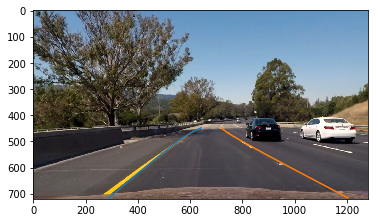

In [13]:
undist = undistort_transform(img)
plt.imshow(undist)

unwarp_curve1 = np.array([unwarp_transform_p(p) for p in np.stack([curve_x(y, coef1), y], axis=1)])
unwarp_curve2 = np.array([unwarp_transform_p(p) for p in np.stack([curve_x(y, coef2), y], axis=1)])
plt.plot(unwarp_curve1[:,0], unwarp_curve1[:,1])
plt.plot(unwarp_curve2[:,0], unwarp_curve2[:,1])

# Pipeline

In [29]:
last_coefs = (None, None)

def update_coef(last_coef, new_coef):
    if last_coef is None:
        return new_coef
    else:
        if new_coef is None:
            return last_coef
        else:
            return last_coef*0.8+new_coef*0.2

def process(img):
    global last_coefs
    (last_coef1, last_coef2) = last_coefs
    
    dst = undistort_transform(img)
    binary = transform_threshold_binary(img)
    warped = undistort_warp_transform(binary)
    (coef1, coef2) = fit_curve(warped, last_coef1, last_coef2)
    
    y = np.arange(img.shape[0])
    
    coef1 = update_coef(last_coef1, coef1)
    coef2 = update_coef(last_coef2, coef2)
    
    if coef1 is not None:
        unwarp_curve1 = np.array([unwarp_transform_p(p) for p in np.stack([curve_x(y, coef1), y], axis=1)])
        cv2.polylines(dst, np.array([unwarp_curve1], dtype=np.int32), False, color=[0,255,0], thickness=2)
        
    if coef2 is not None:
        unwarp_curve2 = np.array([unwarp_transform_p(p) for p in np.stack([curve_x(y, coef2), y], axis=1)])
        cv2.polylines(dst, np.array([unwarp_curve2], dtype=np.int32), False, color=[0,255,0], thickness=2)
    
    if coef1 is not None and coef2 is not None:
        (lane_width, lane_offset, lane_radius) = curve_geometry(coef1, coef2)
        ok = (lane_width > 3. and lane_width < 4.)
        text_color = (255, 255, 255) if ok else (255, 0, 0)
        cv2.putText(dst, 'Radius: %.0f m' % lane_radius, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color)
        cv2.putText(dst, 'Width: %.2f m' % lane_width, (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color)
        cv2.putText(dst, 'Offset: %.2f m' % lane_offset, (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color)
        
    else:
        cv2.putText(dst, 'N/A', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
    
    
    last_coefs = (coef1, coef2)
    return dst

Wall time: 347 ms


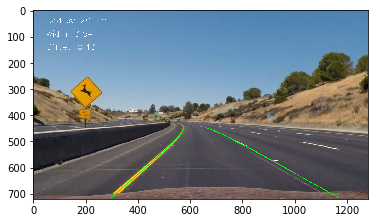

In [6]:
img = mpimg.imread('test_images/test2.jpg')
%time dst = process(img)
plt.imshow(dst)

In [71]:
for infile in glob.glob('test_images/test**.jpg'):
    last_coefs = (None, None)
    outfile = infile.replace('test_images', 'output_images')
    img = mpimg.imread(infile)
    %time dst = process(img)
    mpimg.imsave(outfile, dst)

Wall time: 296 ms
Wall time: 296 ms
Wall time: 288 ms
Wall time: 300 ms
Wall time: 306 ms
Wall time: 303 ms


# Video processing

In [27]:
%matplotlib inline

In [31]:
# Run process on videos

from moviepy.editor import VideoFileClip
from IPython.display import HTML

input_dir = './'
output_dir = 'output_videos/'
fname = 'project_video.mp4'

last_coefs = (None, None)
clip_in = VideoFileClip(input_dir + fname)
clip_out = clip_in.fl_image(process)
clip_out.write_videofile(output_dir + fname, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_dir + fname))

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4



  5%|████▎                                                                           | 67/1261 [00:23<06:55,  2.87it/s]


 11%|████████▍                                                                      | 135/1261 [00:47<06:32,  2.87it/s]


 16%|████████████▋                                                                  | 203/1261 [01:15<06:31,  2.70it/s]


 21%|████████████████▉                                                              | 271/1261 [01:42<06:15,  2.64it/s]


 27%|█████████████████████▏                                                         | 339/1261 [02:06<05:44,  2.67it/s]


 32%|█████████████████████████▍                                                     | 407/1261 [02:30<05:15,  2.71it/s]


 38%|█████████████████████████████▊                                                 | 475/1261 [02:53<04:47,  2.73it/s]


 43%|██████████████████████████████████                                             | 543/1261 [03:17<04:20,  2.75it/s]


 48%|██████████████████████████████████████▎                                        | 611/1261 [03:40<03:54,  2.77it/s]


 54%|██████████████████████████████████████████▌                                    | 679/1261 [04:05<03:30,  2.77it/s]


 59%|██████████████████████████████████████████████▊                                | 747/1261 [04:28<03:04,  2.78it/s]


 65%|███████████████████████████████████████████████████                            | 815/1261 [04:51<02:39,  2.79it/s]


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [05:14<02:14,  2.80it/s]


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [05:40<01:50,  2.80it/s]


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [06:05<01:26,  2.79it/s]


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [06:31<01:02,  2.78it/s]


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [06:56<00:38,  2.77it/s]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [07:22<00:13,  2.77it/s]


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:37<00:00,  2.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 



In [7]:
# Cut shorter clip
clip_in = VideoFileClip('project_video.mp4')
clip_out = clip_in.subclip(0, 1)
clip_out.write_videofile('project_video_cut.mp4', audio=False)

[MoviePy] >>>> Building video project_video_cut.mp4
[MoviePy] Writing video project_video_cut.mp4


 96%|█████████████████████████████████████████████████████████████████████████████▉   | 25/26 [00:00<00:00, 107.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_cut.mp4 

